In [1]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import openmatrix as omx
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
def read_matrix_from_omx_file(file, core, row_map="zone_number", col_map="zone_number"):
    if type(file) == str:
        file = omx.open_file(file)
        
    matrix_df = pd.DataFrame(file[core][:])
    if row_map is not None:
        inv_row_map = file.mapping(row_map)
        row_map = {taz1: taz2 for taz2, taz1 in inv_row_map.items()}
        inv_col_map = file.mapping(col_map)
        col_map = {taz1: taz2 for taz2, taz1 in inv_col_map.items()}
    else:
        row_map = {i: i+1 for i in range(len(matrix_df))}
        col_map = {i: i+1 for i in range(len(matrix_df))}
    matrix_df.rename(index=row_map, columns=col_map, inplace=True)
    return matrix_df

In [3]:
output_dir = r'C:\abm_runs\rsg\abm3_dev\run_dir\output_full\archive\25pct-run_shared_apr12'

In [4]:
households = pd.read_csv(os.path.join(output_dir, 'final_households.csv'))
persons = pd.read_csv(os.path.join(output_dir, 'final_persons.csv'))
tours = pd.read_csv(os.path.join(output_dir, 'final_tours.csv'))
trips = pd.read_csv(os.path.join(output_dir, 'final_trips.csv'))
landuse = pd.read_csv(os.path.join(output_dir, 'final_land_use.csv'))

C:\Users\davidh\AppData\Local\Temp\2\ipykernel_62368\2432087234.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(output_dir, 'final_tours.csv'))


In [5]:
md_skims = omx.open_file(r'C:\abm_runs\rsg\abm3_dev\run_dir\data_full\traffic_skims_processed_MD.omx')
sov_md_dist = read_matrix_from_omx_file(md_skims, 'SOV_TR_M_DIST__MD', 'zone_number', 'zone_number')
sov_md_dist = sov_md_dist.melt(ignore_index=False).reset_index()
sov_md_dist.columns = ['origin', 'destination', 'dist']

In [6]:
sov_md_dist.head()

,origin,destination,dist
0,1,1,0.787847
1,2,1,11.893787
2,3,1,13.119427
3,4,1,38.945305
4,5,1,66.265656


In [7]:
households

,household_id,home_zone_id,income,hhsize,HHT,auto_ownership,num_workers,sample_rate,income_in_thousands,income_segment,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_6_to_12,num_children_5_to_15,num_children_16_to_17,num_gradeschool,num_highschool,num_college_age,num_young_adults,num_predrive_child,num_nonworker_adults,num_fullTime_workers,num_partTime_workers,non_family,family,home_is_urban,home_is_rural,hh_work_auto_savings_ratio,transponder_ownership,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours
0,3,16,236389,2,3,1,0,0.251,236.389,4,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,False,True,False,False,0.0,False,0,2,1,0,1,2,True,0_tours,0
1,4,27,121977,2,2,2,2,0.251,121.977,4,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,False,True,False,False,0.0,False,0,2,2,0,0,2,True,0_tours,0
2,9,43,126505,4,1,4,3,0.251,126.505,4,1,4,4,0,0,0,0,0,0,0,0,0,0,0,3,0,False,True,False,False,0.0,False,0,4,4,0,0,4,True,0_tours,0
3,12,50,102770,2,5,2,2,0.251,102.770,4,0,2,2,0,0,0,0,0,0,0,0,0,0,0,1,1,True,False,False,False,0.0,False,0,2,2,0,0,2,True,1_Eat,1
4,15,17,234965,2,1,2,1,0.251,234.965,4,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,False,True,False,False,0.0,False,0,2,2,0,0,2,True,0_tours,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1197115,15304,14000,1,0,1,1,0.251,14.000,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,False,False,False,False,0.0,False,0,1,1,0,0,1,False,0_tours,0
299996,1197118,15304,14000,1,0,2,1,0.251,14.000,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,False,False,False,False,0.0,False,0,0,0,0,0,0,False,0_tours,0
299997,1197121,15304,14000,1,0,1,1,0.251,14.000,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,False,False,False,False,0.0,False,0,1,1,0,0,1,False,0_tours,0
299998,1197122,15300,14000,1,0,1,1,0.251,14.000,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,False,False,False,False,0.0,False,0,0,0,0,0,0,False,0_tours,0


## Household Variables

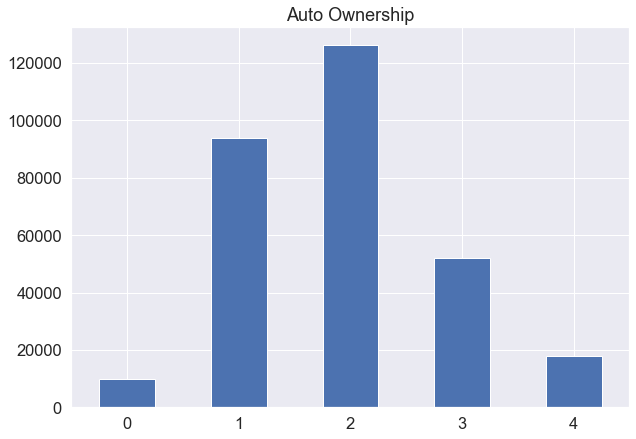

In [8]:
plt.figure(figsize=(10,7))
households.auto_ownership.value_counts().loc[[0,1,2,3,4]].plot(kind='bar')
plt.title('Auto Ownership')
plt.xticks(rotation=0)
plt.show()

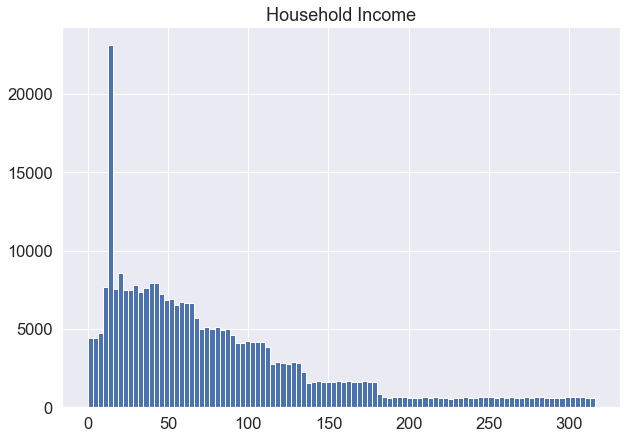

In [9]:
plt.figure(figsize=(10,7))
households.income_in_thousands.hist(bins=100)
plt.title('Household Income')
plt.show()

In [10]:
households.income_in_thousands.value_counts()

14.000     15739
20.380        91
4.529         86
24.909        85
29.437        83
           ...  
101.275        1
53.235         1
80.576         1
60.339         1
191.273        1
Name: income_in_thousands, Length: 123803, dtype: int64

Lots of households have an annual income of exactly $14,000

## Person Variables

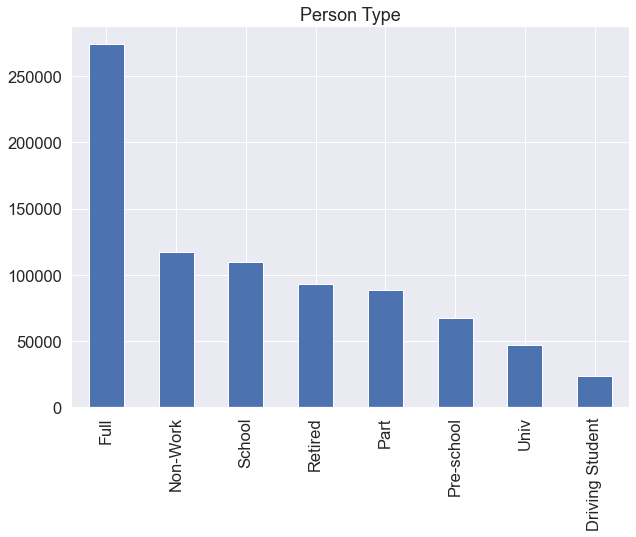

In [11]:
person_type_dict = {
    1: 'Full',
    2: 'Part',
    3: 'Univ',
    4: 'Non-Work',
    5: 'Retired',
    6: 'Driving Student',
    7: 'School',
    8: 'Pre-school'
}
persons['ptype_named'] = persons['ptype'].map(person_type_dict)

plt.figure(figsize=(10,7))
persons.ptype_named.value_counts().plot(kind='bar')
plt.title('Person Type')
plt.show()

## Purpose

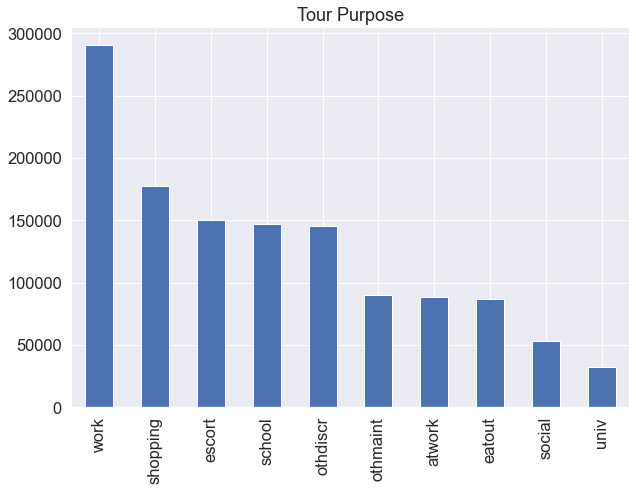

In [12]:
plt.figure(figsize=(10,7))
tours.primary_purpose.value_counts().plot(kind='bar')
plt.title('Tour Purpose')
plt.show()

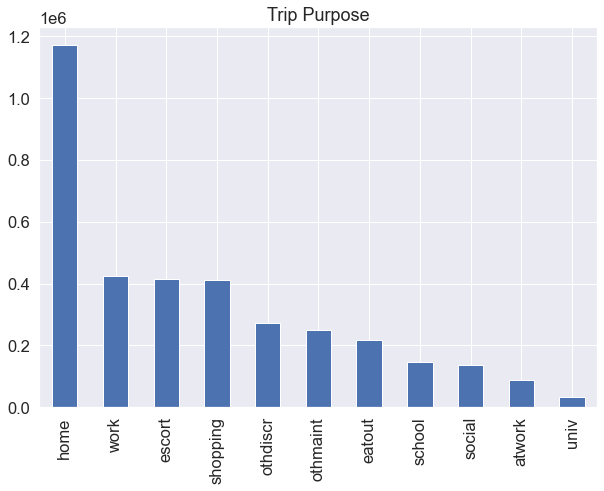

In [13]:
plt.figure(figsize=(10,7))
trips.purpose.value_counts().plot(kind='bar')
plt.title('Trip Purpose')
plt.show()

## Mode

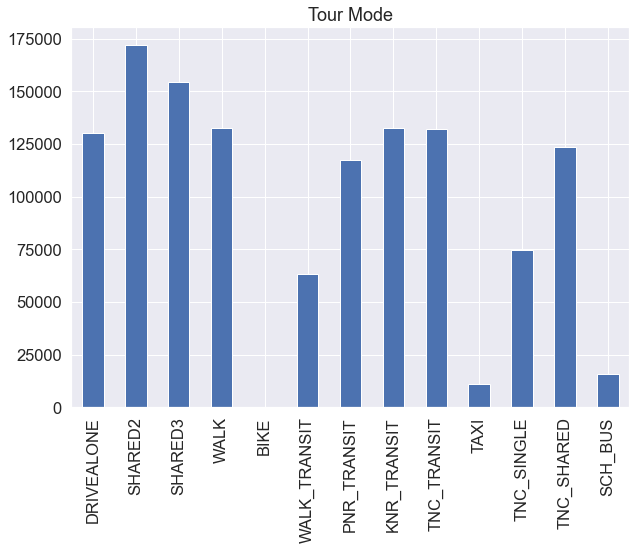

In [14]:
mode_order = ['DRIVEALONE','SHARED2','SHARED3','WALK','BIKE','WALK_TRANSIT','PNR_TRANSIT','KNR_TRANSIT','TNC_TRANSIT','TAXI','TNC_SINGLE','TNC_SHARED','SCH_BUS']
tour_modes = tours.tour_mode.value_counts()
missing_modes = [mode for mode in mode_order if mode not in tour_modes.index]
for missing_mode in missing_modes:
    tour_modes.loc[missing_mode] = 0

plt.figure(figsize=(10,7))
tour_modes.loc[mode_order].plot(kind='bar')
plt.title('Tour Mode')
plt.show()

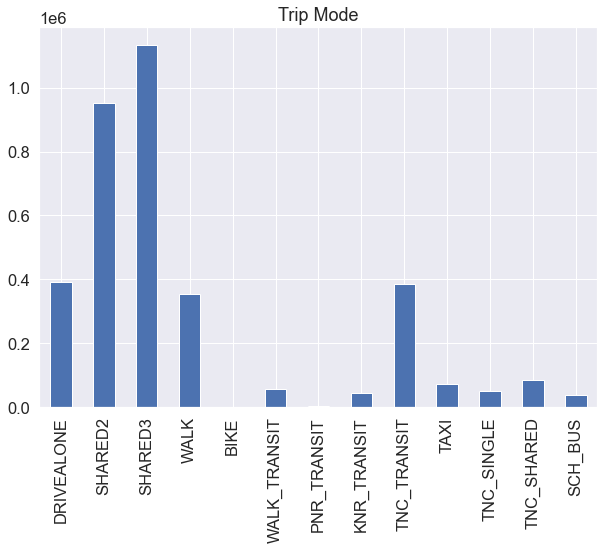

In [15]:
trip_modes = trips.trip_mode.value_counts()
missing_modes = [mode for mode in mode_order if mode not in trip_modes.index]
for missing_mode in missing_modes:
    trip_modes.loc[missing_mode] = 0

plt.figure(figsize=(10,7))
trip_modes.loc[mode_order].plot(kind='bar')
plt.title('Trip Mode')
plt.show()

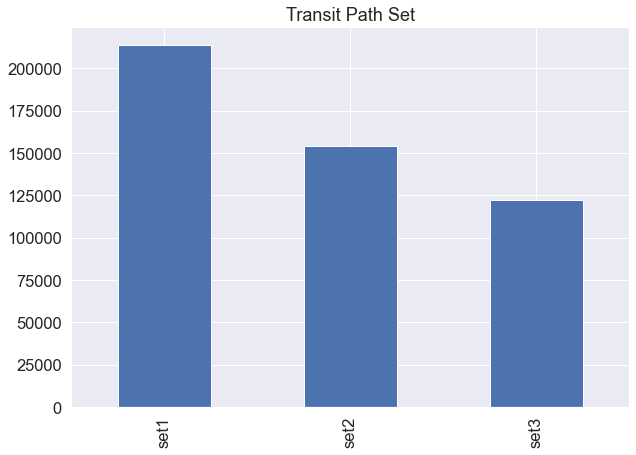

In [16]:
plt.figure(figsize=(10,7))
trips.path_set.value_counts().plot(kind='bar')
plt.title('Transit Path Set')
plt.show()

## Scheduling

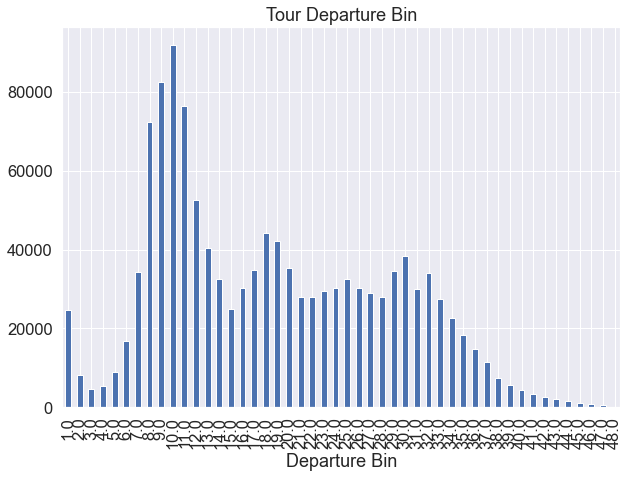

In [50]:
plt.figure(figsize=(10,7))
tours.start.value_counts().loc[range(1,49)].plot(kind='bar')
plt.title('Tour Departure Bin')
plt.xlabel('Departure Bin')
plt.show()

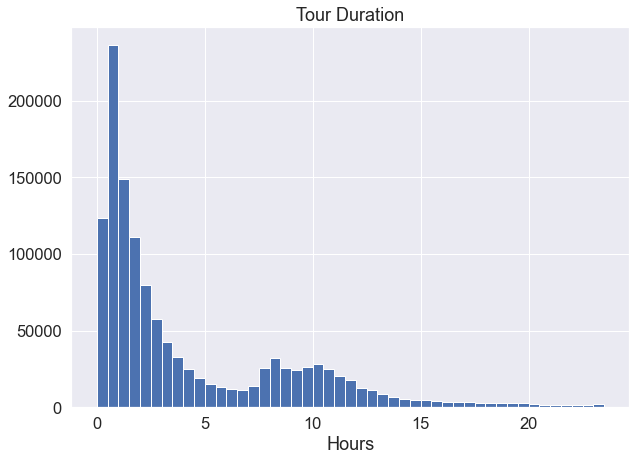

In [56]:
plt.figure(figsize=(10,7))
(tours.duration / 2).hist(bins=47)
plt.title('Tour Duration')
plt.xlabel('Hours')
plt.show()

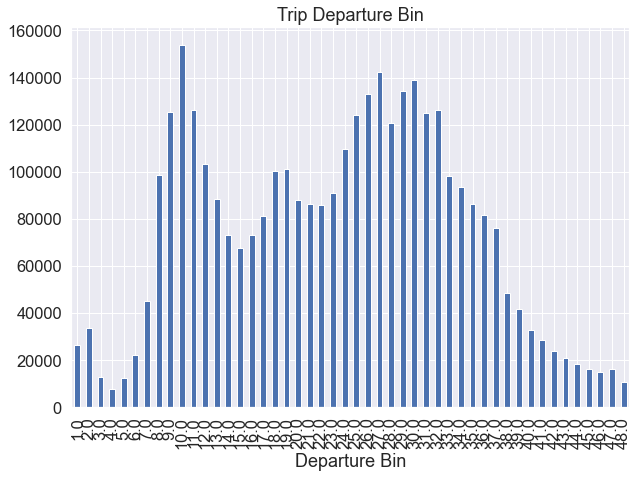

In [48]:
plt.figure(figsize=(10,7))
trips.depart.value_counts().loc[range(1,49)].plot(kind='bar')
plt.title('Trip Departure Bin')
plt.xlabel('Departure Bin')
plt.show()

## Location Choice

In [17]:
maz_taz_xwalk = landuse.set_index('zone_id')['TAZ'].to_dict()
tours['origin_taz'] = tours['origin'].map(maz_taz_xwalk)
tours['destination_taz'] = tours['destination'].map(maz_taz_xwalk)

trips['origin_taz'] = trips['origin'].map(maz_taz_xwalk)
trips['destination_taz'] = trips['destination'].map(maz_taz_xwalk)

tours_with_dist = pd.merge(tours, sov_md_dist, how='left', left_on=['origin_taz', 'destination_taz'], right_on=['origin', 'destination'])
trips_with_dist = pd.merge(trips, sov_md_dist, how='left', left_on=['origin_taz', 'destination_taz'], right_on=['origin', 'destination'])

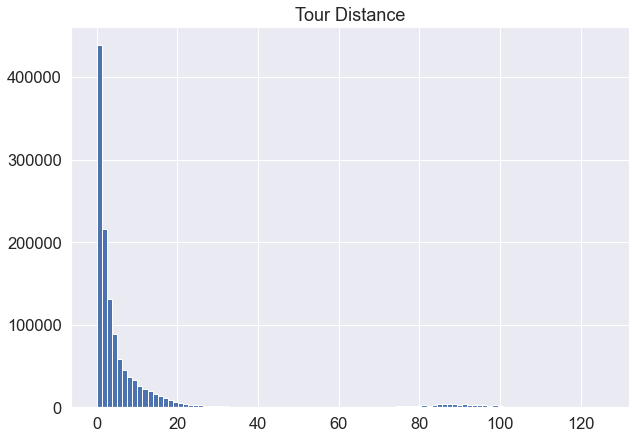

In [18]:
plt.figure(figsize=(10,7))
tours_with_dist.dist.hist(bins=100)
plt.title('Tour Distance')
plt.show()

In [19]:
tours_with_dist[tours_with_dist.dist > 80].primary_purpose.value_counts()

school      48066
shopping       41
othmaint       32
othdiscr       20
social         16
escort         15
eatout          9
atwork          6
Name: primary_purpose, dtype: int64

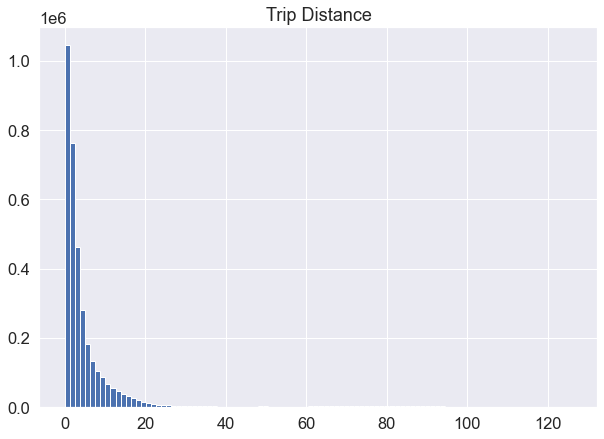

In [20]:
plt.figure(figsize=(10,7))
trips_with_dist.dist.hist(bins=100)
plt.title('Trip Distance')
plt.show()

In [21]:
trips_with_dist[trips_with_dist.dist > 80].purpose.value_counts()

school      25222
home         7257
othdiscr     5406
escort       3275
shopping     3138
othmaint     2882
social       2579
eatout       2418
work            6
atwork          2
Name: purpose, dtype: int64

Some school tours and trips are very long!!

## Timing

In [22]:
timing_log = pd.read_csv(os.path.join(output_dir, 'timing_log.csv'))

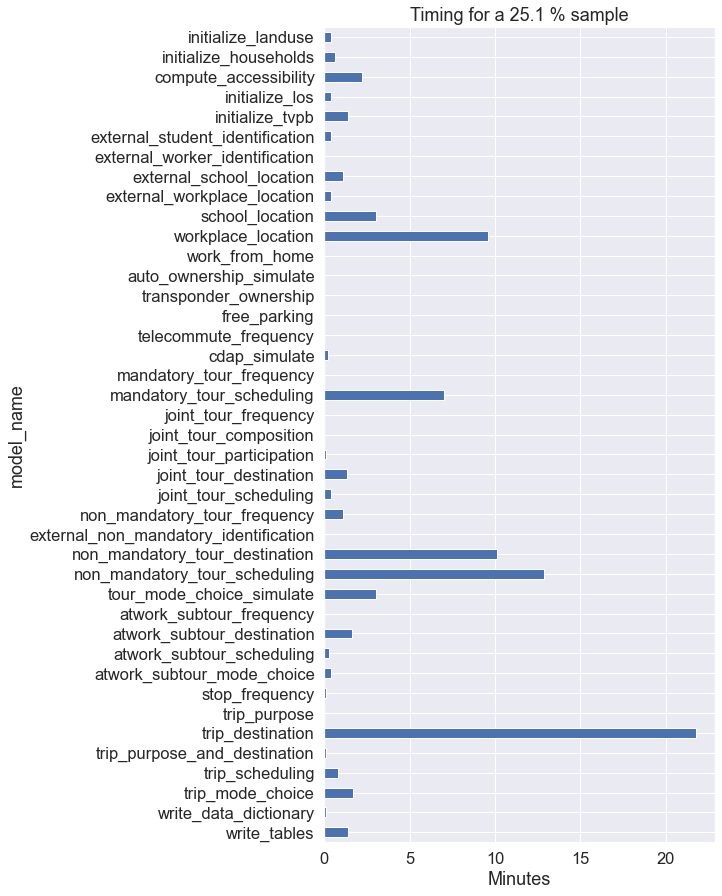

Total model run time: 83.9 minutes = 1.3983333333333334 hours


In [23]:
plt.show()
order = timing_log.loc[timing_log.index.sort_values(ascending=False),'model_name'].values
plt.figure(figsize=(7,15))
timing_log.set_index('model_name').loc[order].minutes.plot.barh()
plt.xlabel('Minutes')
plt.title(f'Timing for a {round(households.sample_rate.mean()*100, 1)} % sample')
plt.show()
print(f"Total model run time: {timing_log.minutes.sum()} minutes = {timing_log.minutes.sum() / 60} hours")

While timing log says run took only 84 mins, the anaconda prompt has a time of 124.6 mins to complete....

## Trip Purpose and Destination
What is the profile of failed trips?

In [57]:
trips

,trip_id,person_id,household_id,primary_purpose,trip_num,outbound,trip_count,destination,origin,tour_id,purpose,destination_logsum,depart,trip_mode,mode_choice_logsum,atap,btap,path_set,origin_taz,destination_taz
0,1889,5,3,school,1,True,2,2420,16,236,escort,-9.888394,9.0,WALK_TRANSIT,0.133346,2007.0,1648.0,set3,3458,4237
1,1890,5,3,school,2,True,2,21557,2420,236,school,NaN,9.0,SHARED2,-9.059300,NaN,NaN,NaN,4237,252
2,1893,5,3,school,1,False,4,3159,21557,236,othmaint,-9.301515,42.0,SHARED2,-9.746948,NaN,NaN,NaN,252,3532
3,1894,5,3,school,2,False,4,101,3159,236,eatout,15.731910,42.0,TNC_SHARED,0.330974,NaN,NaN,NaN,3532,3549
4,1895,5,3,school,3,False,4,2487,101,236,social,16.224949,42.0,SHARED2,0.458200,NaN,NaN,NaN,3549,4138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568346,1071080377,3265488,1197126,work,1,True,1,14875,15300,133885047,work,NaN,9.0,SHARED3,-2.454449,NaN,NaN,NaN,15,421
3568347,1071080381,3265488,1197126,work,1,False,2,14590,14875,133885047,shopping,7.775248,9.0,TNC_TRANSIT,-0.045737,251.0,244.0,set1,421,513
3568348,1071080382,3265488,1197126,work,2,False,2,15300,14590,133885047,home,NaN,11.0,SHARED3,-1.878301,NaN,NaN,NaN,513,15
3568349,1071080385,3265488,1197126,work,1,True,1,14875,15300,133885048,work,NaN,24.0,DRIVEALONE,-1.525944,NaN,NaN,NaN,15,421


In [24]:
failed_trips = pd.read_csv(os.path.join(output_dir, 'trip_purpose_and_destination_i5_failed_trips.csv'))

In [25]:
failed_trips = pd.merge(failed_trips, tours, how='left', on='tour_id', suffixes=('', '_tour'))

In [26]:
failed_trips.tour_mode.value_counts()

WALK    148
Name: tour_mode, dtype: int64

In [27]:
failed_trips.origin.value_counts()

15304    117
15307      8
20788      3
21426      3
21397      3
14640      3
21864      2
20972      2
21432      2
21387      1
20789      1
21081      1
11431      1
14569      1
Name: origin, dtype: int64

In [28]:
landuse[landuse.zone_id.isin(failed_trips.origin)]

,zone_id,TAZ,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,gq_civ,gq_mil,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,hhs,pop,hhp,emp_ag,emp_const_non_bldg_prod,emp_const_non_bldg_office,emp_utilities_prod,emp_utilities_office,emp_const_bldg_prod,emp_const_bldg_office,emp_mfg_prod,emp_mfg_office,emp_whsle_whs,emp_trans,emp_retail,emp_prof_bus_svcs,emp_prof_bus_svcs_bldg_maint,emp_pvt_ed_k12,emp_pvt_ed_post_k12_oth,emp_health,emp_personal_svcs_office,emp_amusement,emp_hotel,emp_restaurant_bar,emp_personal_svcs_retail,emp_religious,emp_pvt_hh,emp_state_local_gov_ent,...,hstallssam,hparkcost,numfreehrs,dstallsoth,dstallssam,dparkcost,mstallsoth,mstallssam,mparkcost,zip09,parkactive,openspaceparkpreserve,beachactive,budgetroom,economyroom,luxuryroom,midpriceroom,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,totint,duden,empden,popden,retempden,totintbin,empdenbin,dudenbin,PopEmpDenPerMi,poe_id,original_MAZ,external_TAZ,external_MAZ,external_size_term_placeholder,colonia_pop_accessibility,external_work,external_nonwork,household_density,employment_density,density_index,is_cbd
11430,11431,1699,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0,4,0,60,63,47,7,27,11,30,13,0,131,35,0,0,0,...,0,0,0,0,0,0,0,0,0,92128,0.0,0.0000,0.0000,0,0,0,0,0,0,42,1,4,11.4625,13.9169,13.9169,13.9169,120,0,0,47,3.0077,9.7052,6.5297,3.6870,1,1,1,10390.3331,-1,-1,-1,-1,0,NaN,0.0,0.0,0.000000,30.753975,0.000000,False
14568,14569,451,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,3,0,0,65,2,0,0,0,...,0,0,0,0,0,0,0,0,0,92054,0.0,8.8675,5.5026,0,0,0,0,0,0,1,1,1,0.1637,42.0398,7.1103,42.0398,120,0,0,52,3.2040,1.8991,7.7892,1.2808,1,1,1,6200.5190,-1,-1,-1,-1,0,NaN,0.0,0.0,0.000000,1.879172,0.000000,False
14639,14640,574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,63,10,3,0,0,0,26,0,0,56,48,0,0,0,...,0,0,0,0,0,0,0,0,0,92054,0.0,0.0000,0.0000,0,0,0,0,0,0,1,1,1,0.4597,2.8780,2.8780,2.8780,120,0,0,257,5.8950,9.2858,15.6410,3.4743,3,1,2,15953.0992,-1,-1,-1,-1,0,NaN,0.0,0.0,0.000000,71.577484,0.000000,False
15303,15304,143,4144,4144,0,0,4109,4109,0,0,0,1583,186,879,1346,609,422,298,188,61,72,48,3.707,16814,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,...,0,0,0,0,0,0,0,0,0,92055,0.0,0.0000,0.0000,0,0,0,0,0,0,156,1,1,3.9563,23979.9822,23892.0769,23905.2068,120,0,0,0,0.0000,0.0000,0.0000,0.0000,1,1,1,0.0000,-1,-1,-1,-1,0,NaN,0.0,0.0,0.171351,0.576898,0.098852,False
15306,15307,16,1168,1168,0,0,1155,1155,0,0,0,0,62,266,387,143,101,92,55,12,25,12,3.675,4245,4245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,14,0,...,0,0,0,0,0,0,0,0,0,92672,0.0,0.0000,0.0000,0,0,0,0,0,0,156,1,1,1.6003,1256.2760,1227.2145,1256.2760,120,0,0,0,0.0000,0.0000,0.0000,0.0000,1,1,1,0.0000,-1,-1,-1,-1,0,NaN,0.0,0.0,0.919384,1.640563,0.589195,False
20787,20788,168,21,21,0,0,18,18,0,0,0,0,4,4,1,1,2,3,0,1,0,2,2.778,50,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,92060,0.0,0.0000,0.0000,0,0,0,0,0,0,202,1,14,30.5050,20.8049,20.8049,20.8049,120,0,0,6,0.3866,0.0111,1.0932,0.0000,1,1,1,706.7697,-1,-1,-1,-1,0,NaN,0.0,0.0,0.865181,0.000000,0.000000,False
20788,20789,168,48,48,0,0,39,39,0,0,0,0,6,7,6,2,3,5,6,1,2,1,2.692,105,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,92060,0.0,0.0000,0.0000,0,0,0,0,0,0,202,1,14,30.7197,52.3129,52.3054,52.3129,120,0,0,5,0.6902,0.0217,1.9403,0.0000,1,1,1,1255.7032,-1,-1,-1,-1,0,NaN,0.0,0.0,0.745514,0.000000,0.000000,False
20971,20972,304,27,27,0,0,23,23,0,0,0,0,3,8,2,3,1,3,2,1,0,0,2.348,54,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,92066,0.0,0.0000,0.0000,0,0,0,0,0,0,203,1,14,44.3024,344.6564,344.6564,344.6564,120,0,0,5,0.0667,0.0000,0.1567,0.0000,1,1,1,100.2738,-1,-1,-1,-1,0,NaN,0.0,0.0,0.066733,0.000000,0.000000,False
21080,21081,1666,11,11,0,0,7,7,0,0,0,0,1,0,1,3,1,0,0,0,1,0,2.571,18,18,0,0,0,0,0,0

There are 148 trips that had to be removed from the trip list due to failing in the trip destination and scheduling model after 5 iteration attempts.  All of them occur on walk tours, and the vast majority are from a trip that originates in the large MAZs associated with military bases (15304 and 15307).